### 【#6】bin化 + TE

In [1]:
# ライブラリのインポート
import numpy as np
import pandas as pd
import os

# データフレーム読み込み
train_df = pd.read_csv("/kaggle/input/playground-series-s5e9/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s5e9/test.csv")

# データ結合
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

In [2]:
# 数値列とカテゴリ列を取得
num_col = []
cat_col = []
TARGET = "BeatsPerMinute"

for col in train_df.drop(["id",TARGET],axis=1).columns:
    if train_df[col].dtypes!="object":
        num_col.append(col)
    else:
        cat_col.append(col)

In [3]:
train_ = train_df.copy()
test_ = test_df.copy()

In [4]:
# ビン化する
eps = 1e-8
CATS = []
def tobin(train, test):
    for col in num_col:
        maxbin = train[col].max()
        minbin = train[col].min()
        bins_ = np.linspace(minbin - eps, maxbin + eps, 10)

        CAT = col+"_bin"
        train[CAT] = pd.cut(train[col], bins=bins_, labels=False)
        test[CAT] = pd.cut(test[col], bins=bins_, labels=False)

    return train, test

train_, test_ = tobin(train_, test_)

In [5]:
# # すべての特徴量を0-1でmin-maxスケールする
# # 既に与えられて特徴量がクリップで潰れているため
# from sklearn.preprocessing import MinMaxScaler

# train_ = train_df.copy()
# test_ = test_df.copy()

# scaler = MinMaxScaler()
# cols = num_col[:-1]

# train_[cols] = scaler.fit_transform(train_[cols])
# test_[cols] = scaler.transform(test_[cols])

In [6]:
# # 最大、最小値はクリップされているので特徴として加える
# def clip(df):

#     for col in num_col[:-1]:

#         # 最小値クリップ
#         if(df.loc[df[col]==df[col].min(),col].count()/(len(df))>0.01):
    
#             df[col + "_min"] = 0
#             df.loc[df[col]==df[col].min(),col + "_min"] = 1
#             df[col + "_min"] = df[col + "_min"].astype("category")

#         # 最大値クリップ
#         if(df.loc[df[col]==df[col].max(),col].count()/(len(df))>0.01):

#             # 最大値クリップ
#             df[col + "_max"] = 0
#             df.loc[df[col]==df[col].max(),col + "_max"] = 1
#             df[col + "_max"] = df[col + "_max"].astype("category")

# clip(train_)
# clip(test_)

In [7]:
# # BPMを7ビンに分ける
# maxbin = train_df["BeatsPerMinute"].max()
# minbin = train_df["BeatsPerMinute"].min()
# bins = np.linspace(minbin,maxbin,8) # 7ビンに分ける

# df = train_df.copy()
# df = train_df.drop("id",axis=1)
# df["BPM_bin"] = pd.cut(df["BeatsPerMinute"],bins=bins,labels=False)

In [8]:
# # 各ビンの中央値で差し引く
# for i in range(7):
#     df.loc[df["BPM_bin"]==i,feat] = df.loc[df["BPM_bin"]==i,feat] - df.loc[df["BPM_bin"]==i,feat].median()

In [9]:
# 訓練データとテストデータに分離
# train = all_df[:len(train_df)]
# test = all_df[len(train_df):]

# 訓練データをx,yに分割
# X_train = train_df.drop(["id","BeatsPerMinute"],axis=1)
# y_train = train_df["BeatsPerMinute"]
# X_test = test_df.drop("id",axis=1)

# X_train = train.drop(["id","BeatsPerMinute","BPM_bin"],axis=1)
# y_train = train["BeatsPerMinute"]
# X_test = test.drop("id",axis=1)

In [10]:
# y_train.describe()

### 【Light GBM】

In [11]:
###################################################
############ Light GBM ############################
###################################################
import lightgbm as lgb
from sklearn.model_selection import KFold

# 学習、バリデーションデータ
pred_lgb = np.zeros(len(train_df))
pred_lgb_test = np.zeros(len(test_df))
models_lgb = []

# 入力データ
X = train_.drop(["id","BeatsPerMinute"],axis=1)
y = train_["BeatsPerMinute"]
test= test_.drop("id",axis=1)

# 評価履歴を格納する辞書
evals_result_lgb = {}

# パラメータ
lgbm_params = {
    'objective': 'regression',
    "device": "cpu",
    # "device": "gpu",
    'metric': 'rmse',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    # 'feature_fraction': 0.6956717916553479,
    # 'num_leaves':       153,
    # 'bagging_fraction': 0.5279852787927486,
    # 'bagging_freq':     4,
    # 'lambda_l1':        0.004603414256652151,
    # 'lambda_l2':        0.013858762846118894,
    # 'min_data_in_leaf': 87,
    }

# クロスバリデーション
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold,(train_idx,valid_idx) in enumerate(kf.split(X)):

    print("#"*25)
    print(f"### Folf {fold+1}")
    print("#"*25)
    
    X_train = X.iloc[train_idx,:]
    y_train = y.iloc[train_idx]
    X_valid = X.iloc[valid_idx,:]
    y_valid = y.iloc[valid_idx]

    # ターゲットエンコーディング
    for i,c in enumerate(CATS):
        if i%10==0: print(f"{i}, ",end="")
            
        TE0 = TargetEncoder(n_folds=5, smooth=10, split_method='random', stat='median')
        X_train[c] = TE0.fit_transform(X_train[c],y_train).astype('float32')
        X_valid[c] = TE0.transform(X_valid[c]).astype('float32')
        X_test[c] = TE0.transform(X_test[c]).astype('float32')
        
    print()    

    # TE0を明示的に削除
    # del TE0
    # gc.collect()

    # CC以外はカテゴリ型に変換
    for c in CATS:
        X_train[c] = X_train[c].astype('category')
        X_valid[c] = X_valid[c].astype('category')
        X_test[c]  = X_test[c].astype('category')    

    # データセット作成
    lgb_train_lgb = lgb.Dataset(X_train,y_train,
                               categorical_feature=CATS)
    lgb_valid_lgb = lgb.Dataset(X_valid,y_valid,
                               categorical_feature=CATS)


    # 学習
    model_lgb = lgb.train(
        lgbm_params,
        lgb_train_lgb,
        num_boost_round=2000,
        valid_sets=[lgb_train_lgb,lgb_valid_lgb],
        valid_names=["train","valid"],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100,verbose=False),
            lgb.record_evaluation(evals_result_lgb),
            lgb.log_evaluation(100),])

    # 各foldでのバリデーション予測
    pred_lgb[valid_idx] = model_lgb.predict(
        X_valid, num_iteration=model_lgb.best_iteration) 
    
    # モデルの追加
    models_lgb.append(model_lgb)

    # テストの予測
    pred_lgb_test = pred_lgb_test + model_lgb.predict(
        test, num_iteration=model_lgb.best_iteration) / 5

# FOLD数で割る
# pred_lgb_test = pred_lgb_test/5

#########################
### Folf 1
#########################

[100]	train's rmse: 26.4506	valid's rmse: 26.438
[200]	train's rmse: 26.436	valid's rmse: 26.4378
[300]	train's rmse: 26.422	valid's rmse: 26.4382
#########################
### Folf 2
#########################

[100]	train's rmse: 26.4393	valid's rmse: 26.4839
[200]	train's rmse: 26.4243	valid's rmse: 26.4831
[300]	train's rmse: 26.4104	valid's rmse: 26.4836
#########################
### Folf 3
#########################

[100]	train's rmse: 26.4294	valid's rmse: 26.5238
[200]	train's rmse: 26.4138	valid's rmse: 26.5232
#########################
### Folf 4
#########################

[100]	train's rmse: 26.4495	valid's rmse: 26.4446
[200]	train's rmse: 26.4349	valid's rmse: 26.4428
[300]	train's rmse: 26.4212	valid's rmse: 26.4427
#########################
### Folf 5
#########################

[100]	train's rmse: 26.4581	valid's rmse: 26.4084
[200]	train's rmse: 26.4428	valid's rmse: 26.4078
[300]	train's rmse: 26.4289	valid

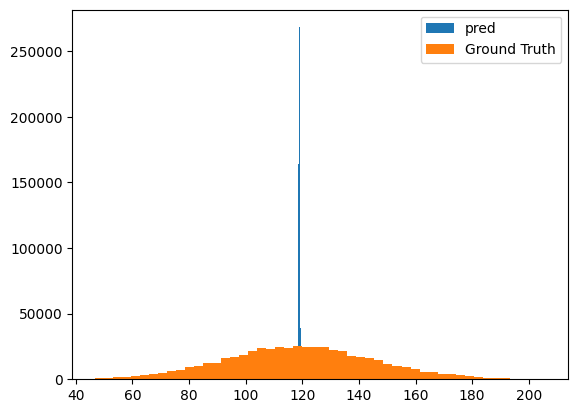

In [12]:
import matplotlib.pyplot as plt

plt.hist(pred_lgb,bins=50,label="pred")
plt.hist(y,bins=50,label="Ground Truth")
plt.legend()
plt.show()

LGB: RMSE score = 26.458845709515426


<Axes: title={'center': 'LightGBM RMSE'}, xlabel='Iterations', ylabel='rmse'>

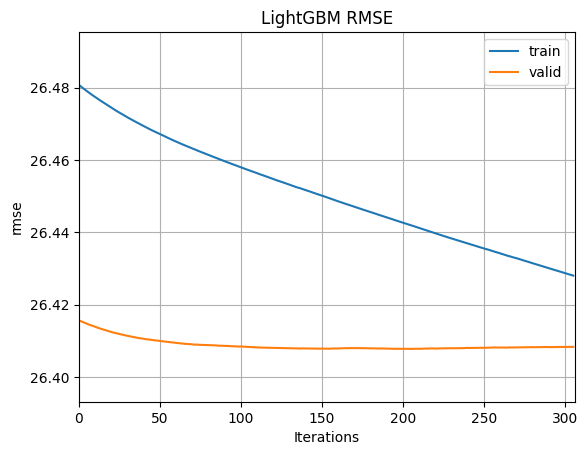

In [13]:
# 訓練データのスコア
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

RMSE_lgb = np.sqrt(mean_squared_error(y,pred_lgb))
print(f"LGB: RMSE score = {RMSE_lgb}")

# 学習曲線
lgb.plot_metric(evals_result_lgb,title="LightGBM RMSE",)

In [14]:
# 提出データ作成
sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e9/sample_submission.csv")

sample_submission['BeatsPerMinute'] = pred_lgb_test
sample_submission.to_csv('submission.csv', index=False)
print('Submission file saved.')

Submission file saved.
